In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("measurements.csv")

# Subtract start time.
start = data.t.values[0]
data.t -= start
# To ms.
data.t /= 1000000
# data.t.values[0]
data.head()

,t,vout,code
0,0.0000,0.0000,0.0
1,3.9681,0.0005,0.0
2,7.9489,0.0010,0.0
3,11.9426,0.0015,0.0
4,15.9621,0.0020,0.0


Let's try to find the last transition

In [4]:
res = 2 ** 10
# vref = 4.575
vref = 4.613
data["vin"] = data.code * vref / res
# data.vin

last_transition_v = vref / res * (res - 1)
print(last_transition_v)
last_transition = data[data.vout >= last_transition_v].iloc[0].name

# Keep only the data up until the last transition.
data = data[:last_transition]

4.6084951171875


## Calculate the statistics.

Coefficient = 221.98135703446778.
LinregressResult(slope=1.0068426627921538, intercept=-0.005482351799691809, rvalue=0.9999982774653673, pvalue=0.0, stderr=1.9467647769882024e-05, intercept_stderr=5.1798899770804095e-05)
0.0045048828125
Offset error = 1.2053110239433575 LSB, full-scale error: -5.740363441407454 LSB, gain error = 6.945674465350812 LSB.


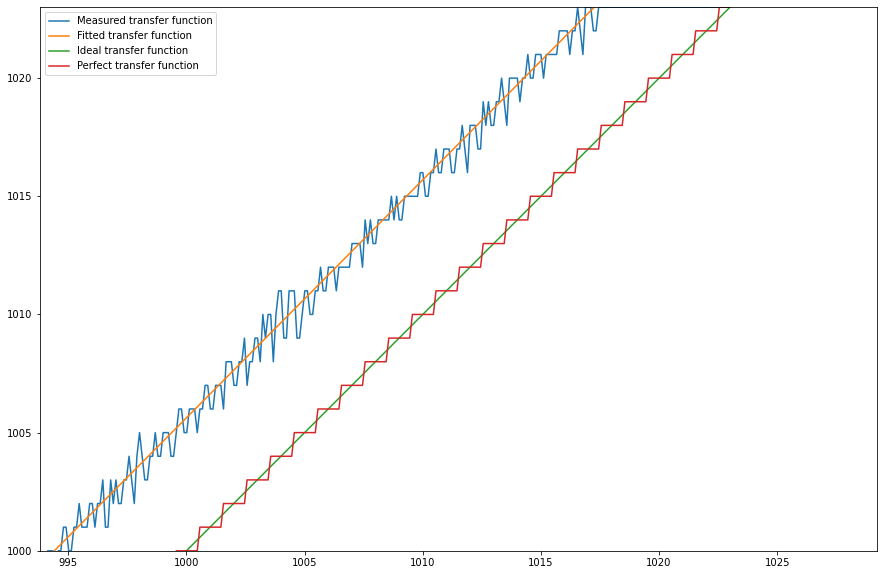

In [6]:
from scipy.stats import linregress

def v_to_code(voltage):
    global res, vref
    return voltage * res / vref

def perfect_adc_code(voltage):
    global res, vref
    return np.round(voltage * res / vref) / (res / vref)

code = True
if code:
    coef = res / vref
else:
    coef = 1
print(f"Coefficient = {coef}.")


# Perform linear regression using least squares.
lr = linregress(x=data.vout, y=data.vin)
print(lr)

fig, ax = plt.subplots(figsize=(15, 10))

# print(perfect_adc_code(data.vout))
# print(v_to_code(data.vout))

ax.axis("equal")
# Plot the voltages.
limits = [0 * coef, 0.025 * coef]
limits = [1000, 1023]
# limits = [0, 1024]
ax.plot(data.vout * coef, data.vin * coef, label="Measured transfer function")
ax.plot(data.vout * coef, (lr.slope * data.vout + lr.intercept) * coef, label="Fitted transfer function")
ax.plot(data.vout * coef, data.vout * coef, label="Ideal transfer function")
ax.plot(data.vout * coef, perfect_adc_code(data.vout) * coef, label="Perfect transfer function")

# Set the limits to display only a part of the plot.
ax.set_xlim(limits)
ax.set_ylim(limits)

# Set the legend.
ax.legend()

# Calculate offset and gain errors.
lsb_v = vref / res
print(lsb_v)

def calculate_fit_error(lsbs, lsb_v, slope, intercept, verbose=False):
    offset_y = lsbs * lsb_v
    ideal_x = offset_y
    offset_x = (offset_y - intercept) / slope
    if verbose:
        print(f"Offset_x: {offset_x * coef}, offset_y (==ideal_x): {offset_y}.")
    return offset_x - ideal_x

# Offset error calculated at 0.5 LSB.
offset_error_v = calculate_fit_error(0.5, lsb_v, lr.slope, lr.intercept)
# Full-scale error calculated at MAX - 1.5 LSB.
fs_error_v = calculate_fit_error(res - 1.5, lsb_v, lr.slope, lr.intercept)
# Gain error
gain_error_v = -(fs_error_v - offset_error_v)

offset_error = offset_error_v * coef
fs_error = fs_error_v * coef
gain_error = gain_error_v * coef
print(f"Offset error = {offset_error} LSB, full-scale error: {fs_error} LSB, gain error = {gain_error} LSB.")

# plt.show()
# plt.savefig("errors.pdf")